# Astrophysics Laboratory: Data analysis - Stellar clusters
## HIP106409 Data:
Need to have a folder called `All_Images`, with all the images of the night inside.

In [6]:
import os

if not os.path.exists('./Calibrated&Aligned_Lights'):
   os.makedirs('./Calibrated&Aligned_Lights')
if not os.path.exists('./Stacks'):
   os.makedirs('./Stacks')

### Reading previously created (for M39) master bias and master flats:

In [7]:
from astropy.io import fits

masterBias      = fits.open('../M39/Calibration_Frames/masterBias.fits')[0].data
masterFlatRed   = fits.open('../M39/Calibration_Frames/masterFlatRed.fits')[0].data
masterFlatGreen = fits.open('../M39/Calibration_Frames/masterFlatGreen.fits')[0].data
masterFlatBlue  = fits.open('../M39/Calibration_Frames/masterFlatBlue.fits')[0].data

### Image calibration

In [ ]:
from helper_functions import generateCalibratedFrames

dir_lights  = "../M39/All_Images/"
dir_saves   = "./Calibrated&Aligned_Lights/"
generateCalibratedFrames(masterBias, masterFlatRed, dir_lights, dir_saves, "Red",     \
                         silent = False, object = 'hip106049', d = [3, 2, 2]); print()
generateCalibratedFrames(masterBias, masterFlatGreen, dir_lights, dir_saves, "Green", \
                         silent = False, object = 'hip106049', d = [3, 2, 2]); print()
generateCalibratedFrames(masterBias, masterFlatBlue, dir_lights, dir_saves, "Blue",   \
                         silent = False, object = 'hip106049', d = [3, 2, 2])

### Alignment of individual colours using `astroalign`

In [ ]:
from helper_functions import align_colour_frames

light_dir = "./Calibrated&Aligned_Lights/"
saves_dir = light_dir

align_colour_frames(light_dir, saves_dir, "Red", silent = False, object = 'hip106049'); print()
align_colour_frames(light_dir, saves_dir, "Green", silent = False, object = 'hip106049'); print()
align_colour_frames(light_dir, saves_dir, "Blue", silent = False, object = 'hip106049')

### Stacking of individual colours

In [ ]:
from helper_functions import stack_colour_frames

dir_lights  = "./Calibrated&Aligned_Lights/"
dir_saves   = "./Stacks/"

_ = stack_colour_frames(dir_lights, dir_saves, 'Red', silent = False, plot_flag = True, object = 'hip106049')
_ = stack_colour_frames(dir_lights, dir_saves, 'Green', silent = False, plot_flag = True, object = 'hip106049')
_ = stack_colour_frames(dir_lights, dir_saves, 'Blue', silent = False, plot_flag = True, object = 'hip106049')

Alternative (more simplistic) attempt to compute zero-point value.

In [27]:
from helper_functions import *
## Find stars in the field
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats, gaussian_sigma_to_fwhm
from astropy.table import QTable

dir_lights       = "./Stacks/"
red_frame_data   = fits.open(dir_lights + "Red_Stacked.fits")[0].data

init_params = QTable()
init_params['x'] = [791]
init_params['y'] = [539]

# Get background
mean, median, std = sigma_clipped_stats(red_frame_data, sigma = 3.0, maxiters = 5)
# Find stars
daofind = DAOStarFinder(fwhm = 12.0, threshold = 6.0 * std)  ##peakmax to exclude saturated stars!!  

psf_model = IntegratedGaussianPRF(flux = 1, sigma = 10.0 / gaussian_sigma_to_fwhm)
fit_shape = (9, 9)
psfphot = PSFPhotometry(psf_model, fit_shape, finder = daofind,
                        aperture_radius = 12)
phot = psfphot(red_frame_data - median, init_params = init_params)

k, sec_z = 0.09, 1.05
MAG_R = (-2.5 * np.log10(phot['flux_fit']/5.0) - k * sec_z)[0]
M_ZP  = 6.531 - MAG_R
print(f'Obtained m_zp = {M_ZP}.')

Obtained m_zp = 20.898338578245077.


More complete formula

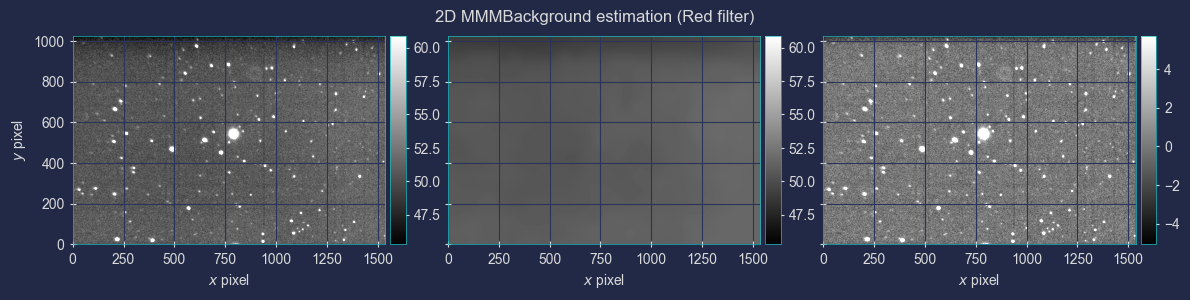

Obtained FWHM values: xfwhm = 7.043056254554283, yfwhm = 8.218114636974398.


Found 110 stars in image (Red filter).


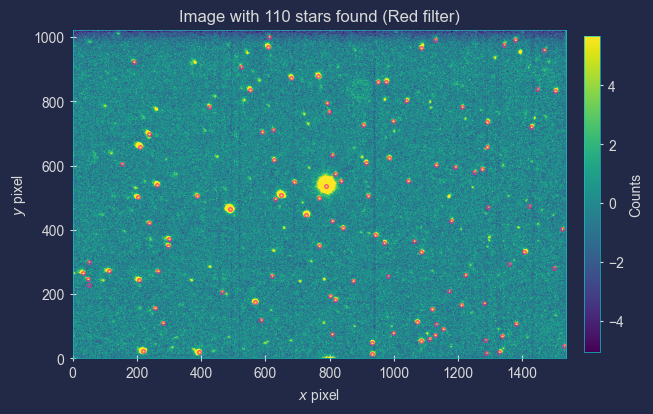

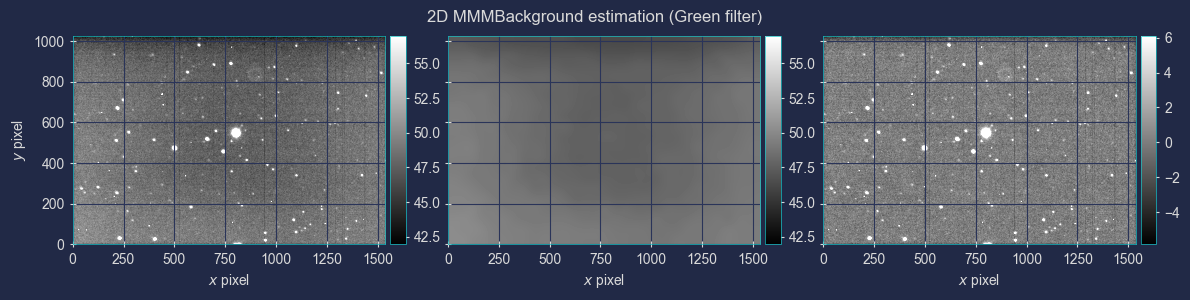

Obtained FWHM values: xfwhm = 8.16313297134722, yfwhm = 7.804471520533334.


Found 77 stars in image (Green filter).


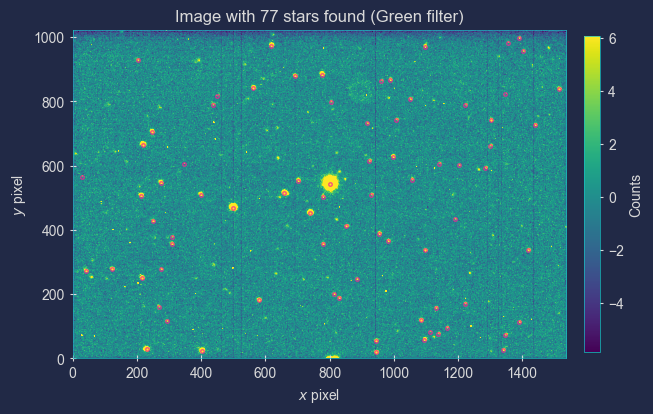

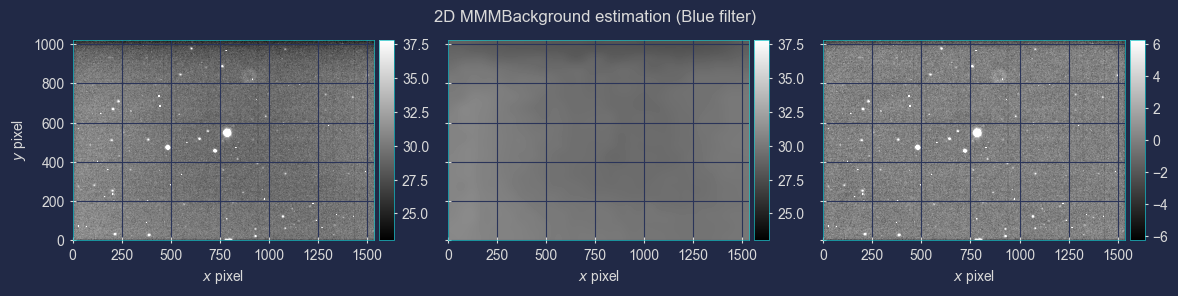

Obtained FWHM values: xfwhm = 6.870141065444807, yfwhm = 7.5296154940493984.
Found 31 stars in image (Blue filter).


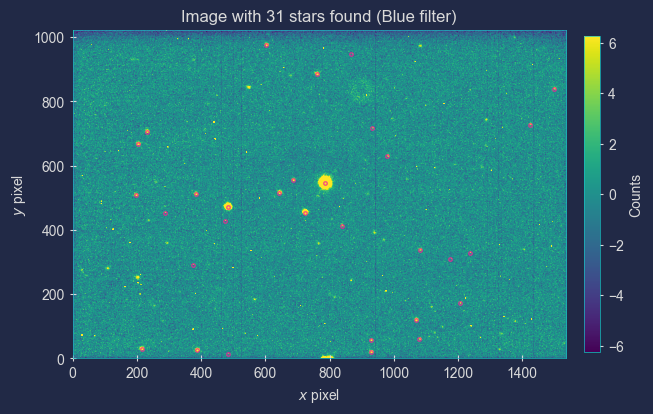

In [18]:
from helper_functions import *

dir_lights       = "./Stacks/"
blue_frame_data  = fits.open(dir_lights + "Blue_Stacked.fits")[0].data
green_frame_data = fits.open(dir_lights + "Green_Stacked.fits")[0].data
red_frame_data   = fits.open(dir_lights + "Red_Stacked.fits")[0].data

red_table   = CreateStarsTable(red_frame_data, iterative = False, filter = "Red", exp_time = 5.0, plot_bkg_flag = True, \
                               plot_stars_flag = True, fit_shape = (11, 11), threshold_sig = 6.0, aperture_radius = 12.0, \
                               grouper_dist = 15.0, model_2D = False, silent = False)

green_table = CreateStarsTable(green_frame_data, iterative = False, filter = "Green", exp_time = 6.0, plot_bkg_flag = True, \
                               plot_stars_flag = True, fit_shape = (11, 11), threshold_sig = 6.0, aperture_radius = 12.0, \
                               grouper_dist = 15.0, model_2D = False, silent = False)

blue_table  = CreateStarsTable(blue_frame_data, iterative = False, filter = "Blue", exp_time = 8.0, plot_bkg_flag = True, \
                               plot_stars_flag = True, fit_shape = (11, 11), threshold_sig = 6.0, aperture_radius = 12.0, \
                               grouper_dist = 15.0, model_2D = False, silent = False)

In [19]:
# Sorting criteria: 'mag'. HIP 106049 is the brightest star in the FOV.
def get_mag(Table):
    return Table['mag']

red_sorted   = Table(rows = sorted(red_table, key   = get_mag), names = red_table.colnames)
green_sorted = Table(rows = sorted(green_table, key = get_mag), names = green_table.colnames)
blue_sorted  = Table(rows = sorted(blue_table, key  = get_mag), names = blue_table.colnames)

# HIP 106049 is the brightest star in the FOV.
magR     = red_sorted['mag'][0]
magR_err = red_sorted['mag_err'][0]

magG     = green_sorted['mag'][0]
magG_err = green_sorted['mag_err'][0]
 
magB     = blue_sorted['mag'][0]
magB_err = blue_sorted['mag_err'][0]

In [20]:
m_ZP_R     = 6.531 - magR
m_ZP_R_err = np.sqrt( 0.001**2 + magR_err**2 )

m_ZP_G     = 6.783 - magG
m_ZP_G_err = np.sqrt( 0.001**2 + magG_err**2 )

m_ZP_B     = 7.082 - magB
m_ZP_B_err = np.sqrt( 0.001**2 + magB_err**2 )

print(f'Obtained zero-points: m_ZP_R = {m_ZP_R:.3f} +/- {m_ZP_R_err:.3f}, m_ZP_G = {m_ZP_G:.3f} +/- {m_ZP_G_err:.3f}, m_ZP_B = {m_ZP_B:.3f} +/- {m_ZP_B_err:.3f}.')

Obtained zero-points: m_ZP_R = 20.427 +/- 0.015, m_ZP_G = 20.405 +/- 0.019, m_ZP_B = 19.802 +/- 0.016.


TODO:
- Should exclude the ones in the outskirts -> These fits are not meaningful! (I've excluded the ones outside the grid, but not yet those in the `bad` alignment regions.);

Note that this H-R diagram might need to be corrected for the distance later (so we have absolute magnitudes, instead of apparent ones).